# Time Series Anaysis

A time series is simply the series of periodic observations of a random variable $X$ depending on time $t$ ($X_t$) over a set of subsequent moments of time $t=1,...,T$ (or $t=1,2,...$ for $T=\infty$):
$$
\{x_t, t=1,...,T\}.
$$
Examples include daily (or hourly or 15/5/1 min) stock prices, weather observations, noise level on the street changing over time, daily/hourly traffic counts, taxi ridership etc.


We assume that there is a certain consistent Data Generating Process behind those observations.
A set of random variables $X_t$ generating a time-series observations is called a stochastic process.

Time increments could be a month, a day, an hour, minute, second, or something smaller.

Typically unless specified otherwise, assume that variables $X_t$ and their observations $x_t$ are real-valued and one-dimentional, however discrete or multidimensional values are also considered in general. 

Goals of time-series analsys are mainly twofold:

#### pattern recognition
(signal detection, financial trends, weekly activity patterns, anomaly detection etc)

#### predictive modelling
(stock prices prediction, weather forecast etc)

Sometimes time-series could be also used for classification purposes, classifying the objects based on temporal variation of a certain parameter, like classification of land use of certain territories based on timeline of human activity there, sound classification etc

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy

### Key Topics in Time Series Analysis

#### 1. Exploratory analysis. Trend detection and detrending. Interpretation.
are there consistent upward or downward patterns in the time-series (trends)? seasonal variations? what are the properties of the residual time-series after all recognizeable temporal patterns are removed? 
#### 2. Forecasting. Serial dependence
are there significant correlations between time-adjacent observations? can we model those?
#### 3. Simulation
based on our knowledge of the time-series patterns and process behind them, estimate probability of certain outcomes through multiple simulations of the process.
#### 4. Control
what is the impact of certain actions on the time-series?
#### 5. Hypothesis testing
prove significance of the hypothesized patterns behind observed time-series.
#### 6. Stationarity 
does the time-series remain stable over time? would it diverge to $\pm \infty$ in finite time? 

In [3]:
import pandas_datareader.data as web

In [4]:
# Grab last 30 years of data of the cost of borrowing
#(from the most liquid market in the world: U.S. debt.)
start, end = "1989-11-01", "2019-11-01"
#tbill3 = web.get_data_yahoo("^IRX", start=start, end=end)['Adj Close']
tbond10 = web.get_data_yahoo("^TNX", start=start, end=end)['Adj Close']

In [5]:
tbond10.head()

Date
1989-11-01    7.91
1989-11-02    7.87
1989-11-03    7.96
1989-11-06    8.00
1989-11-07    7.90
Name: Adj Close, dtype: float64

Text(0, 0.5, '%')

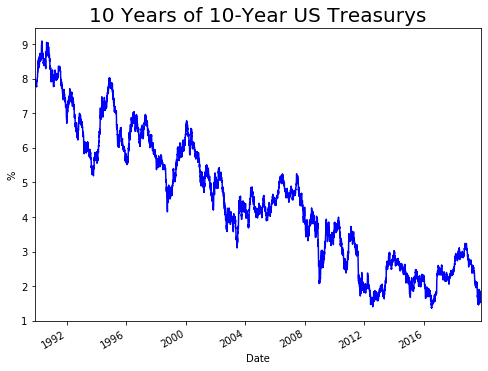

In [6]:
tbond10.plot(color='blue', figsize=(8, 6))
plt.title('10 Years of 10-Year US Treasurys', fontsize=20)
plt.ylabel('%')

In [7]:
dfbond10=pd.DataFrame(tbond10)
dfbond10.head()

,Adj Close
Date,
1989-11-01,7.91
1989-11-02,7.87
1989-11-03,7.96
1989-11-06,8.00
1989-11-07,7.90


### Questions of time-series analysis:

1. is there a trend?

2. is there a period/seasonality?

3. what is not explained by trend/seasonality? what does the "noise" look like? what are the anomalies?

4. can we predict future values?

In [8]:
#ways to assess the trend

In [9]:
(tbond10.loc['2019-11-01']-tbond10.loc['1989-11-01'])/30

-0.20606666008631389

In [10]:
(tbond10.loc['2019-01-02']-tbond10.loc['1990-01-02'])/30

-0.17596666812896727

In [13]:
lm=sm.OLS(dfbond10['Adj Close'],sm.add_constant(dfbond10.index.year)).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 5.455e+04
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:16:23   Log-Likelihood:                -7706.9
No. Observations:                7530   AIC:                         1.542e+04
Df Residuals:                    7528   BIC:                         1.543e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        423.9522      1.796    236.075      0.0

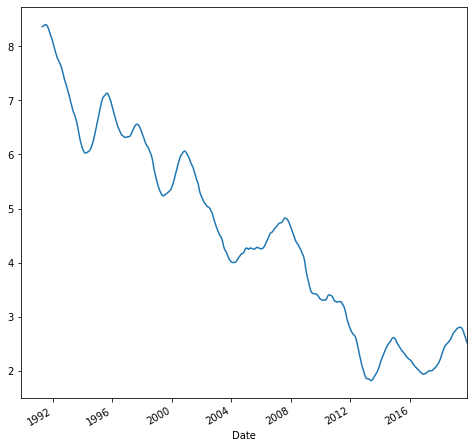

In [66]:
#7 year moving average (avg over the last 7 years)
tbond10.rolling(window = 365).mean().plot()

### Important particular cases of time-series

#### 1. White noise
the process generating values at different moments of time is independent of time and other observations
#### 2. AR,MA,ARMA, ARIMA processes
different combinations of white noise into more sophisticated and applied processes with temporally related observations
#### 3. Random walk process
sequentially modifying single or multi-dimensional variable over time using temporally independent steps (accumulating white noise over time)
#### 4. Markov process (Markov chain)
discrete time-series with limited depth of temporal dependence

## Trend-Seasonality-Noise decomposition

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

**Systematic**: Components of the time series that have consistency or recurrence and can be described and modeled.

**Non-Systematic**: Components of the time series that cannot be directly modeled.
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

A time series is thought to be an aggregate or combination of these four components.
(All series have a level and noise. The trend and seasonality components are optional.)

It is helpful to think of the components as combining either **additively** or **multiplicatively**.

- Additive Model
An additive model suggests that the components are added together as follows:

$ y(t) = Level + Trend + Seasonality + Noise $

An additive model is linear where changes over time are consistently made by the same amount.
A linear trend is a straight line.
A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

- Multiplicative Model
A multiplicative model suggests that the components are multiplied together as follows:

$ y(t) = Level * Trend * Seasonality * Noise $

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.
A nonlinear trend is a curved line.
A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

More precisely a time-series $X_t$ is 
$$
X_t=m_t+s_t+Y_t,
$$
where $m_t$ is the function of $t$, responsible for systematic change of $X$ over time (trend component), $s$ is a periodic function of $t$ (seasonal component) with a known period $d$, such that $s_{t+d}=s_t$ and $\sum_{j=0}^{d-1}s_t=0$, and $Y$ is a stationary time-series. 

Often $s$ represents an annual, weekly or daily variation. Of course not any arbitrary time-series could be represented this way but looking for such representation in a hope for stationarity of residuals $Y_t$ is the goal of classical exploratory analysis.

More generally $s_t$ could be a sum of several periodic functions $s_t=\sum_k s^k_t$ with different periods $d^k$. This allows to account for an overlapping combination of different seasonal variations, such as weekly and daily ones together.

If seasonality period $d$ is known then moving average smoothing with the lag being a factor of $d$ eliminates seasonal component $s_t$ also reducing the relative impact of the residuals (as the variance of an average of $n$ residuals decrease proportionally to $n$) - this was the trend component $m_t$ could be estimated. 

Then once the trend component is removed ($X_t-m_t$) one can focus on estimating $s_\tau, \tau=0..d$ as sample means of the corresponding available observations
$$
s_\tau=\frac{\sum\limits_k x_{k d+\tau}}{|\{k\}|},
$$
since $E[Y_t]=0$.

But what if we do not have a good idea of what the periods could be? Spectral decomposition though Fourier transform technique could help with that. We won't focus too much on the theory and computational approach here.
Both R and python have ready to use tools of estimating this decomposition given the time-series observations (Fast Fourier Transform) as well as estimating the relative strength of different possible periods $d_k$ (periodigram) allowing to pick up the one or several ones, most consistent with the observations. 

In [15]:
dta = pd.DataFrame.from_records(sm.datasets.co2.load().data)
dta['date'] = dta.date.apply(lambda x: x.decode('utf-8'))
dta['date'] = pd.to_datetime(dta.date, format='%Y%m%d')
dta.set_index('date',inplace=True)
dta.co2.interpolate(inplace=True)
#dta.dropna(inplace=True)
dta.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


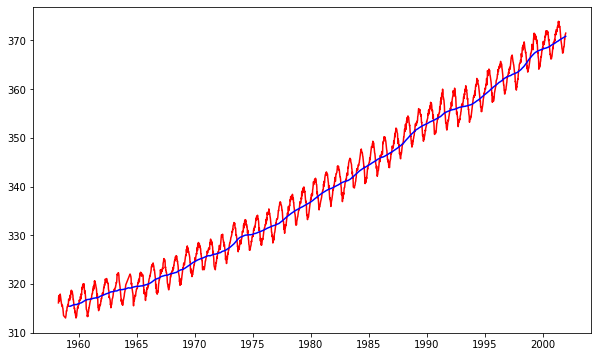

In [16]:
plt.figure(figsize = (10,6))
plt.plot(dta.index,dta.co2, label = 'co2', color = 'red')
plt.plot(dta.index,dta.co2.rolling(window = 52).mean(), label = 'co2', color = 'blue')

In [17]:
matplotlib.rcParams['figure.figsize'] = [8, 8]

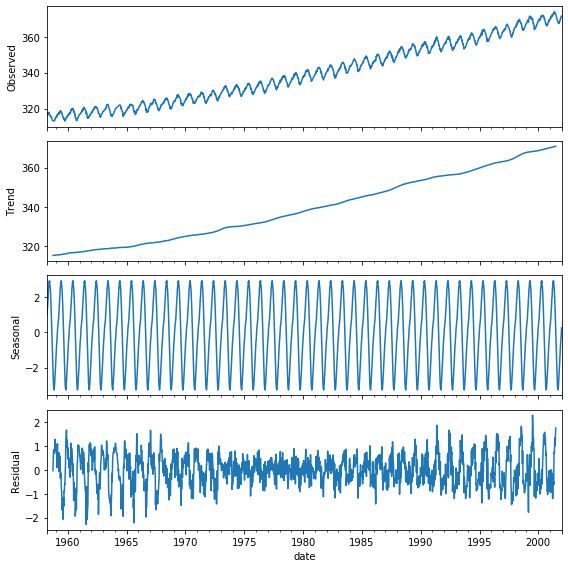

In [18]:
res = sm.tsa.seasonal_decompose(dta,model='additive',freq=52) #try mult
res.plot()
plt.show()

In [19]:
import inspect

In [20]:
inspect.getargspec(sm.tsa.seasonal_decompose)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  """Entry point for launching an IPython kernel.


ArgSpec(args=['x', 'model', 'filt', 'freq', 'two_sided', 'extrapolate_trend'], varargs=None, keywords=None, defaults=('additive', None, None, True, 0))

What if we do not know the period?

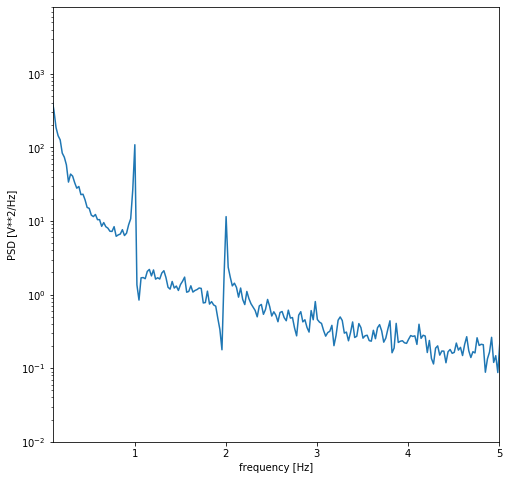

In [21]:
f, PSD = scipy.signal.periodogram(dta.co2, 52) #52 observations per year
plt.semilogy(f, PSD)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(0.1,5)
plt.ylim(0.01,max(PSD))
plt.show()

## Probabilistic time-series model

A time-series model is a specification of all the joint distributions
$$
P(X_t\leq x_t, t=1..T).
$$
Considering an infinite time-series $X_t$ for unlimied $t$ (a stochastic process) the modelling is to specify all the joint distributions
$$
P(X_t\leq x_t, t=1..n)
$$
for all finite $n$.

### 1. IID and white noise

If variables $X_t$ are independent and identically distributed the time-series is called IID. 

If variables $X_t$ are binary random variables (following Bernoulli distribution $X_t\sim Bern(p)$) then the IID time-series is called binary.

The IID time-series with normally distributed $X_t\sim N(0,\sigma^2)$ is called white noise.

Text(0.5, 0, 'Seconds')

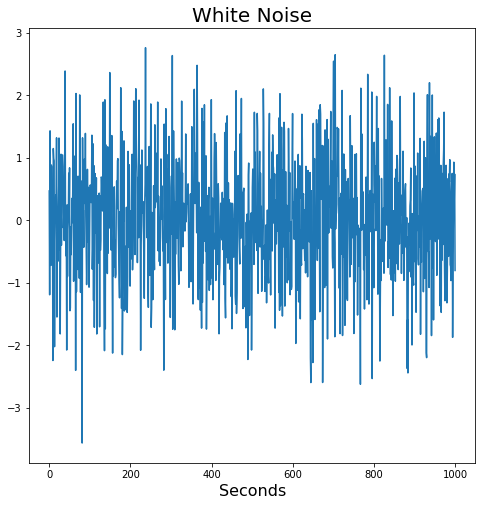

In [22]:
np.random.seed(1234)

nsteps = 1000
noise = np.random.normal(0,1,size=nsteps)

plt.plot(noise)
plt.title('White Noise', fontsize=20)
plt.xlabel('Seconds', fontsize=16)

### 2. Random walk
Random walker process is the time-series (stochastic process), such that 
$$
X_t=X_{t-1}+Y_t
$$
where $Y_t$ is IID. $Y_t$ and $X_t$ could be discrete or continous real-valued; can be also multi-dimensional.

Text(0.5, 0, 'Seconds')

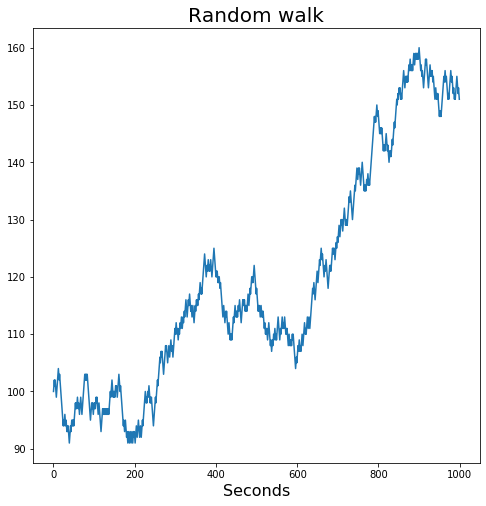

In [23]:
# Simple Application 1: A Random Walk.

# Set an arbitrary starting point and iterate the system using a simple Markov process.
# Each second, this process can move up 1 or it can move down, which it does at random.
# Pr(up) = Pr(down) = 0.5.

# pos is starting position.
# draws are random integers, {0, 1}.
# step is -1 if random draw is 0 and +1 if random draw is 1.
# walk is the vector containing each step.

np.random.seed(1234)

pos = 100  
walk = [pos] # walk is the array that tracks the random path
nsteps = 2000 # establishs number of random steps
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 # Bernoulli draw to step "up" or "down"
    pos += step
    walk.append(pos)

plt.plot(walk[0:1000])
plt.title('Random walk', fontsize=20)
plt.xlabel('Seconds', fontsize=16)

Text(0.5, 0, 'Seconds')

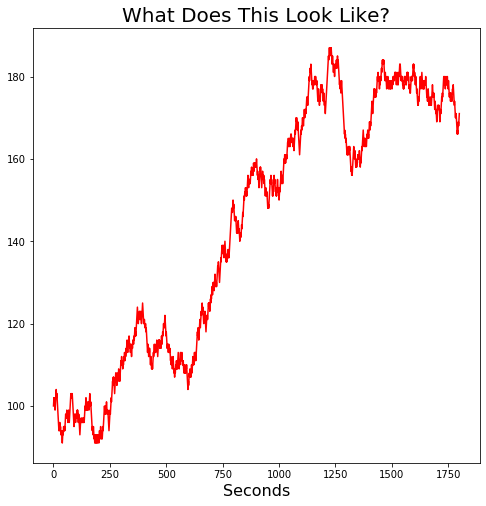

In [24]:
plt.plot(walk[0:1800], 'r')
plt.title("What Does This Look Like?", fontsize=20)
plt.xlabel('Seconds', fontsize=16)

In [27]:
import quandl

In [28]:
#get prices of Apple stock
aapl_all=quandl.get("WIKI/AAPL",start_date="2011-1-1", end_date="2013-1-1")
aapl_all.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2011-01-03,325.6400,330.26,324.8365,329.57,15897800.0,0.0,1.0,41.849279,42.443013,41.746018,42.354338,111284600.0
2011-01-04,332.4400,332.50,328.1500,331.29,11038600.0,0.0,1.0,42.723173,42.730884,42.171849,42.575382,77270200.0
2011-01-05,329.5500,334.34,329.5000,334.00,9125700.0,0.0,1.0,42.351768,42.967350,42.345342,42.923655,63879900.0
2011-01-06,334.7194,335.25,332.9000,333.73,10729600.0,0.0,1.0,43.016108,43.084298,42.782290,42.888956,75107200.0
2011-01-07,333.9900,336.35,331.9000,336.12,11140400.0,0.0,1.0,42.922370,43.225663,42.653776,43.196105,77982800.0


Text(0, 0.5, '$')

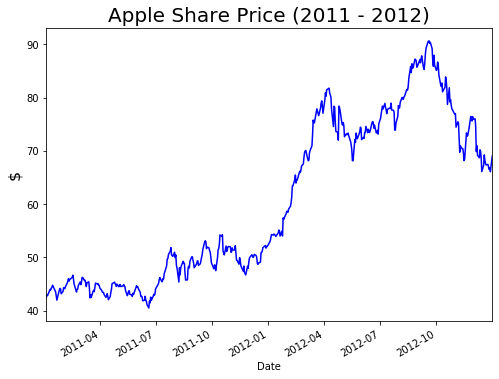

In [29]:
aapl = aapl_all['Adj. Close']
plt.figure(figsize = (8, 6))
aapl.plot(color = 'blue')
plt.title('Apple Share Price (2011 - 2012)', fontsize=20)
plt.ylabel('$', fontsize=16)

Text(0.5, 0, 'Seconds')

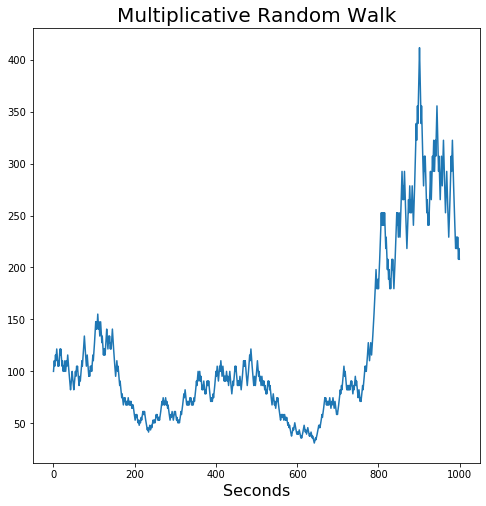

In [30]:
#multiplicative random walk
np.random.seed(12)

pos = 100  
walk = [pos] # walk is the array that tracks the random path
nsteps = 10000 # establishs number of random steps
for i in range(nsteps):
    step = 1.05 if np.random.randint(0, 2) else 1/1.05 # Bernoulli draw to step "up" or "down"
    pos *= step
    walk.append(pos)

plt.plot(walk[0:1000])
plt.title('Multiplicative Random Walk', fontsize=20)
plt.xlabel('Seconds', fontsize=16)

In [31]:
# Simple Application 2: A Drunken Sailor on a Mountaintop

np.random.seed(1234)
#random.seed(10015)
edge = 100
nsteps = 10000

pos1, pos2 = 0, 0  
walk1, walk2 = [pos1], [pos2] 
for i in range(nsteps):
    step1 = 1 if np.random.randint(0, 2) else -1 
    step2 = 1 if np.random.randint(0, 2) else -1
    pos1 += step1
    pos2 += step2
    if np.abs(pos1) > 100 or np.abs(pos2) > 100:
        print("Sailor fell off the moutain at coordinates", pos1, pos2, "on step", i)
        break
    walk1.append(pos1)
    walk2.append(pos2)

Sailor fell off the moutain at coordinates 101 47 on step 3498


(-100, 100)

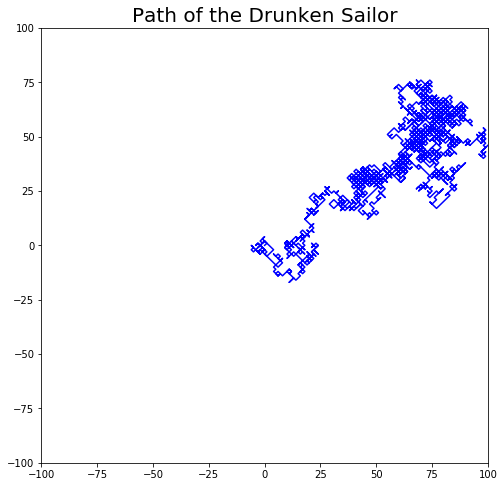

In [32]:
plt.plot(walk1, walk2, 'b')
plt.title("Path of the Drunken Sailor", fontsize=20)
plt.xlim(-edge, edge)
plt.ylim(-edge, edge)

### Stationarity and autocorrelation
It is often the case that time-series values are correlated with past values as change might be relatively small compared to the magnitude of the values. This is for example the case for random walk process. It can be charaterized by the autocorrelation function defined as
$$
\rho(\tau)=corr(X_t,X_{t+\tau})=\frac{Cov(X_t,X_{t+\tau})}{\sqrt{Var[X_t]Var[X_{t+\tau}]}}
$$


Stochastic process is called stationary if its statistical properties do not change over time. The strong stationarity 
means that all the joint distributions
$$
P(X_{t_1+\tau}\leq x_\tau, \tau=0..n)=P(X_{t_2+\tau}\leq x_\tau, \tau=0..n)
$$
do not depend on the specific choice of the initial moment of time $t_1$ or $t_2$.

A more practical definition of the weak stationarity is about having constant mean
$$
E[X_t]=\mu
$$
and having covariation between each two variables $Cov(X_{t_1},X_{t_2})$ in two moments of time $t_1$ and $t_2$ being finite and only depending on the time lag $t_2-t_1$ but not on the spefic moment $t_1$ or $t_2$, i.e.
$$
Cov(X_{t},X_{t+\tau})=Cov(X_{t^*},X_{t^*+\tau})=\gamma(\tau),
$$
where $\gamma$ is a certain symmetric non-negative-valued function of a time lag $\tau$: $\gamma(-\tau)=\gamma(\tau)>0$. $\gamma$ is called autocovariance function. In particular from the above it follows that
$$
Var[X_t]=\gamma(0)=const,
$$
i.e. not only mean, but also variance of all variables $X_t$ is constant. Then autocorrelation function could be defined as
$$
\rho(\tau)=corr(X_t,X_{t+\tau})=\frac{Cov(X_t,X_{t+\tau})}{\sqrt{Var[X_t]Var[X_{t+\tau}]}}=\frac{\gamma(\tau)}{\gamma(0)}
$$
In particular, IID is certainly stationary with 
$$
\rho(\tau)=\left\{\begin{array}{c}1,\ \tau=0,\\0,\ \tau\neq 0.\end{array}\right.
$$  
However stationary time-series are not necessary IID - further we'll consider more sophisticated cases widely applied in finance and other fields. 

Random walk however is not stationary.

Stationarity is an important concept for time-series analysis as stationary processes possess many properties useful for analysis, while for non-stationary processes the objective of the analysis is often seen to transform them to the stationary form (chase for stationarity) - refer to classical decomposition for example.

In [33]:
from statsmodels.graphics.tsaplots import plot_acf

In [34]:
pd.DataFrame({'Returns':aapl,'Lag returns':aapl.shift(1)}).dropna().corr() #correlation is strong but will decrease with lag

,Returns,Lag returns
Returns,1.000000,0.997342
Lag returns,0.997342,1.000000


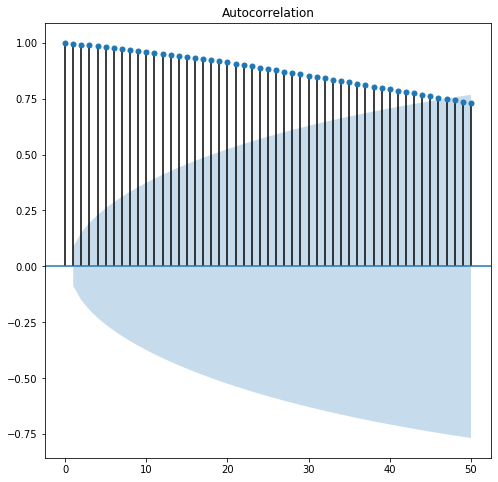

In [35]:
#autocorrelation in apple stock prices
plot_acf(aapl, lags=50);

In [36]:
#stock prices have obvious autocorrelation but the daily changes do not
appl_ret=np.log(aapl)-np.log(aapl.shift(1))

In [37]:
appl_ret.shift(1).head()

Date
2011-01-03         NaN
2011-01-04         NaN
2011-01-05    0.005205
2011-01-06    0.008147
2011-01-07   -0.000809
Name: Adj. Close, dtype: float64

In [38]:
pd.DataFrame({'Returns':appl_ret,'Lag returns':appl_ret.shift(1)}).dropna().corr()

,Returns,Lag returns
Returns,1.000000,-0.001785
Lag returns,-0.001785,1.000000


In [39]:
appl_ret.head()

Date
2011-01-03         NaN
2011-01-04    0.005205
2011-01-05    0.008147
2011-01-06   -0.000809
2011-01-07    0.007136
Name: Adj. Close, dtype: float64

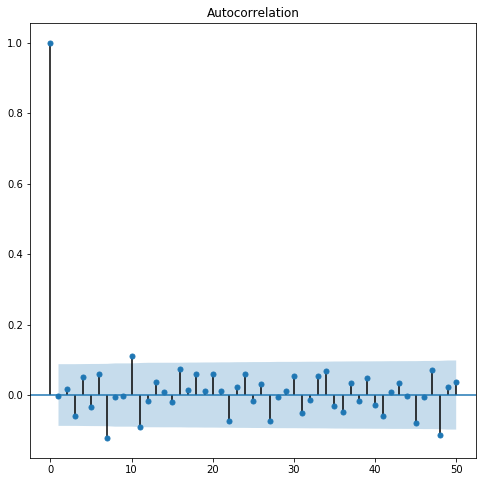

In [72]:
plot_acf(appl_ret.dropna(), lags=50);

# Urban case: FHV ridership near PENN Station

## 1. Visualization of Different Traffic Flows 
What can we tell from the plots of daily count 

In [41]:
# import dataset
hourlyData = pd.read_csv('PENN_ts.csv')
hourlyData.head()

,time,fhv,yellow
0,18/1/1 0:00,147,319
1,18/1/1 1:00,347,397
2,18/1/1 2:00,370,385
3,18/1/1 3:00,264,300
4,18/1/1 4:00,157,196


In [42]:
# get the number of samples
nsamp = len(hourlyData)
# convert the `date` feature into `dt.datetime` format. This is for later datetime operations
Time = []
for i in range(0,nsamp):
    time = dt.datetime.strptime(hourlyData['time'].loc[i],"%y/%m/%d %H:%M")
    Time.append(time)
hourlyData['time'] = Time
# print dataset characteristics
print('This is the original dataset characteristics:')
timeperiod = Time[-1] - Time[0] + dt.timedelta(hours = 1)
# this is the duration of our observations: tail - head + 1 
print('The time period for this dataset is: ', timeperiod.days)
print('The number of observations are: ', nsamp)
print(hourlyData.describe())

This is the original dataset characteristics:
The time period for this dataset is:  365
The number of observations are:  8760
               fhv       yellow
count  8760.000000  8760.000000
mean    172.821918   398.510616
std      91.476470   201.925694
min       0.000000     0.000000
25%     105.000000   205.750000
50%     175.000000   447.000000
75%     230.000000   543.000000
max     615.000000  1032.000000


In [43]:
#aggregate data into n hour bins for clarity of visualization
n = 24
nHourFHV = hourlyData.fhv.rolling(window = n).sum().iloc[(n-1)::n]
nHourYELLOW = hourlyData.yellow.rolling(window = n).sum().iloc[(n-1)::n]
nHourData = pd.DataFrame({'time':hourlyData.time.iloc[(n-1)::n],'fhv': nHourFHV, 'yellow': nHourYELLOW})
nHourData.head()

,time,fhv,yellow
23,2018-01-01 23:00:00,4477.0,9282.0
47,2018-01-02 23:00:00,3262.0,9713.0
71,2018-01-03 23:00:00,3238.0,10324.0
95,2018-01-04 23:00:00,1651.0,4782.0
119,2018-01-05 23:00:00,3444.0,9068.0


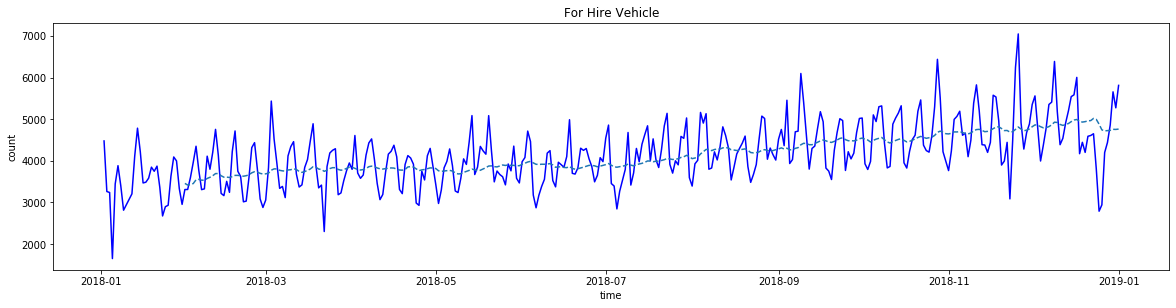

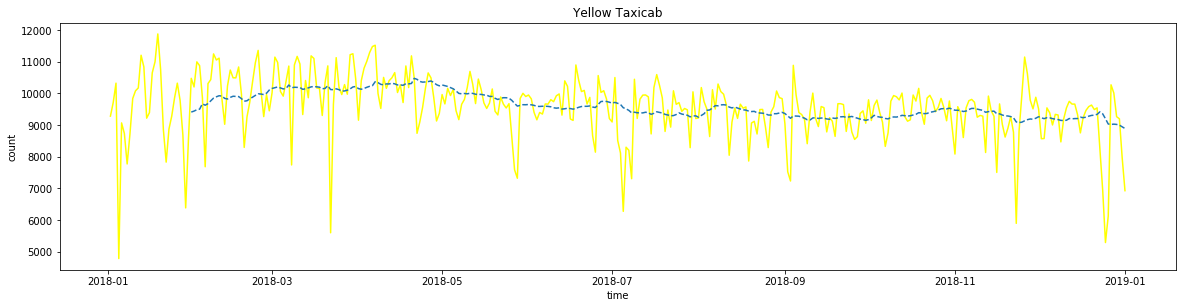

In [44]:
# plot the dialy `fhv` and `yellow` on the timeline to see their tendency
# the '--' line is 30-day moving average
xTime = nHourData['time']
yFHV = nHourData['fhv']
yYellow = nHourData['yellow']
plt.figure(figsize = (20,10))
plt.subplot(211)
plt.title('For Hire Vehicle')
plt.xlabel('time')
plt.ylabel('count')
FHV_ata_line = plt.plot(xTime,yFHV, label = 'FHV', color = 'blue')
FHV_mean_line = plt.plot(xTime,yFHV.rolling(window = 30).mean(), label='FHV Mean', linestyle='--')

xTime = nHourData['time']
yFHV = nHourData['fhv']
yYellow = nHourData['yellow']
plt.figure(figsize = (20,10))
plt.subplot(212)
plt.title('Yellow Taxicab')
plt.xlabel('time')
plt.ylabel('count')
yellow_data_line = plt.plot(xTime,yYellow, label = 'Yellow Taxicab', color = 'yellow')
yellow_mean_line = plt.plot(xTime,yYellow.rolling(window = 30).mean(), label='Yellow Mean', linestyle='--')
plt.show()

### Task 1. Use regression model to establish trends in taxi and FHV ridership
We can use nHourData and its index as an hour count from beginning of the year. Which statistics highlights significance of the trend?

In [75]:
lm=sm.OLS(nHourData['yellow'],sm.add_constant(nHourData.index)).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 yellow   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     41.42
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           3.88e-10
Time:                        14:21:30   Log-Likelihood:                -3011.6
No. Observations:                 365   AIC:                             6027.
Df Residuals:                     363   BIC:                             6035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.011e+04     97.511    103.661      0.0

In [76]:
lm2=sm.OLS(nHourData['fhv'],sm.add_constant(nHourData.index)).fit()
print (lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                    fhv   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     178.7
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           2.02e-33
Time:                        14:21:55   Log-Likelihood:                -2852.9
No. Observations:                 365   AIC:                             5710.
Df Residuals:                     363   BIC:                             5718.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3416.5145     63.120     54.127      0.0

## Task 2. Produce seasonal decomposition
Try 24(day) and 168(week) periods

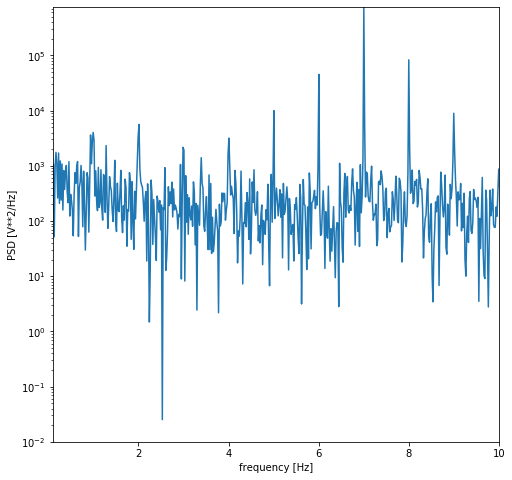

In [45]:
#find possible periods if we're not sure which one to take
f, PSD = scipy.signal.periodogram(hourlyData.yellow, 168) #168 observations per week
plt.semilogy(f, PSD)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(0.1,10)
plt.ylim(0.01,max(PSD))
plt.show()

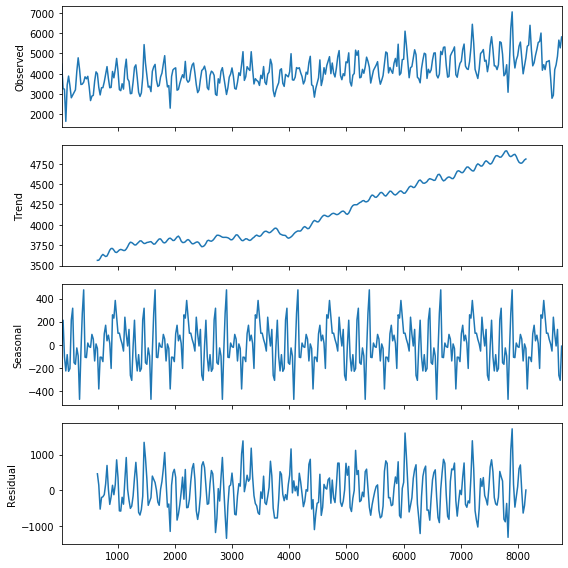

In [79]:
res = sm.tsa.seasonal_decompose(nHourData['fhv'],model='lm2',freq=52) #try mult
res.plot()
plt.show()

## 3. Normality Test for the Noise Distribution
- Histogram Plot

- Statistical Normality Tests 
**Shapiro-Wilk Test** 
The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.
In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.
The shapiro() SciPy function will calculate the Shapiro-Wilk on a given dataset. The function returns both the W-statistic calculated by the test and the p-value.

**D’Agostino’s K^2 Test**
The D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution, named for Ralph D’Agostino.

Skew is a quantification of how much a distribution is pushed left or right, a measure of asymmetry in the distribution.
Kurtosis quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality.
The D’Agostino’s K^2 test is available via the normaltest() SciPy function and returns the test statistic and the p-value.

**Anderson-Darling Test**
Anderson-Darling Test is a statistical test that can be used to evaluate whether a data sample comes from one of among many known data samples, named for Theodore Anderson and Donald Darling.

It can be used to check whether a data sample is normal. The test is a modified version of a more sophisticated nonparametric goodness-of-fit statistical test called the Kolmogorov-Smirnov test.

A feature of the Anderson-Darling test is that it returns a list of critical values rather than a single p-value. This can provide the basis for a more thorough interpretation of the result.

The anderson() SciPy function implements the Anderson-Darling test. It takes as parameters the data sample and the name of the distribution to test it against. By default, the test will check against the Gaussian distribution (dist=’norm’).


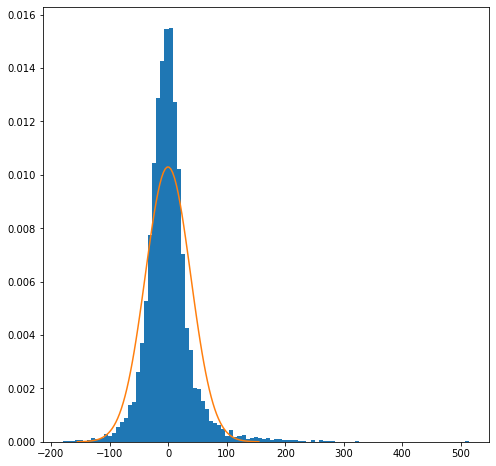

In [46]:
# check the distribution of a sample of data is the histogram
from numpy.random import seed
from numpy.random import randn
# seed the random number generator
seed(1)
# generate univariate observations
# histogram plot
addResult = sm.tsa.seasonal_decompose(hourlyData.fhv, model='additive', freq = 168)
residual = np.array(addResult.resid)
residual = residual[np.logical_not(np.isnan(residual))]
# get rid of nan values from the seasonal_decompose
plt.hist(residual,bins=100,density=True)
sigma=residual.std()
x=np.linspace(-4*sigma,4*sigma,100)
plt.plot(x,scipy.stats.norm.pdf(x,loc=residual.mean(),scale=sigma))
plt.show()

In [47]:
# Shapiro-Wilk Test
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# normality test
stat, p = shapiro(residual)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.888, p=0.000
Sample does not look Gaussian (reject H0)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [48]:
#try on actual normal distribution
seed(1)
stat, p = shapiro(np.random.normal(0,1,size=500)); p

0.753082275390625

In [49]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest
# seed the random number generator
seed(1)
# normality test
stat, p = normaltest(residual)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=3469.109, p=0.000
Sample does not look Gaussian (reject H0)


In [50]:
# Anderson-Darling Test
from scipy.stats import anderson
# seed the random number generator
seed(1)
# normality test
result = anderson(residual)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 175.911
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


## 4. Outlier Detection on Residual


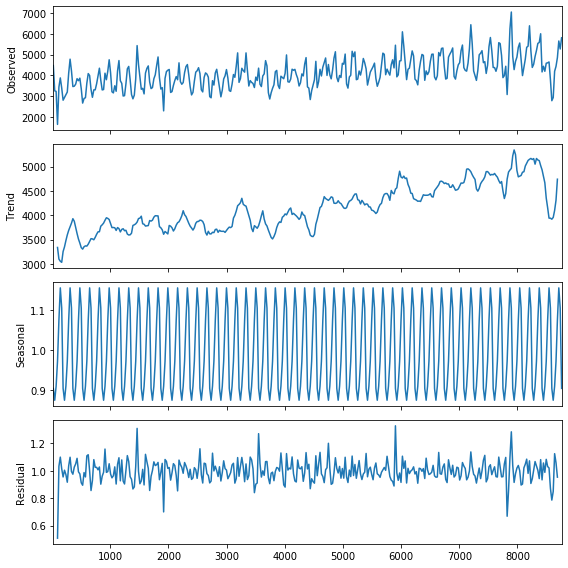

In [51]:
daySeries = nHourData['fhv']
dailyDecomp = seasonal_decompose(daySeries, model='mult', freq = 7)
dailyDecomp.plot();

In [52]:
nHourData.time[dailyDecomp.resid>1.2]

1463   2018-03-02 23:00:00
3551   2018-05-28 23:00:00
4751   2018-07-17 23:00:00
5903   2018-09-03 23:00:00
7895   2018-11-25 23:00:00
Name: time, dtype: datetime64[ns]

In [53]:
nHourData.time[dailyDecomp.resid<0.85]

95     2018-01-04 23:00:00
1919   2018-03-21 23:00:00
3479   2018-05-25 23:00:00
7823   2018-11-22 23:00:00
8591   2018-12-24 23:00:00
8615   2018-12-25 23:00:00
Name: time, dtype: datetime64[ns]

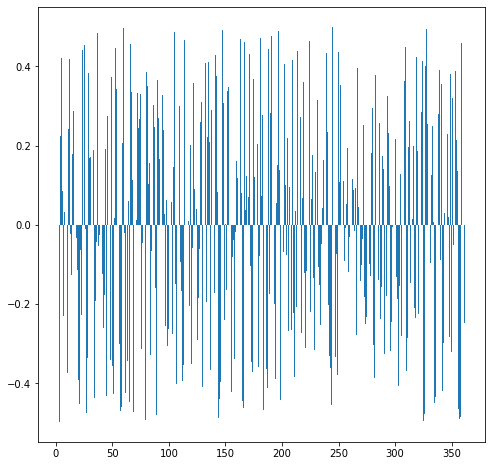

In [54]:
# based on percentile rank
outlierData = pd.DataFrame({})
outlierData['Res'] = dailyDecomp.resid
outlierData['Percentile_rank'] = outlierData.Res.rank(pct = True)-0.5
#plt.figure(figsize = (20,10))
#plt.plot(date, dayData['logRes'])
plt.bar(np.arange(0, len(outlierData)), outlierData['Percentile_rank'])
plt.show()

## Advanced time-series models 


### 1. Moving average process MA(p)
A simple generalization of white noise process is considering it's moving averages
$$
X_t = Y_t+\sum_{j=1}^p \theta_j Y_{t-j}.
$$

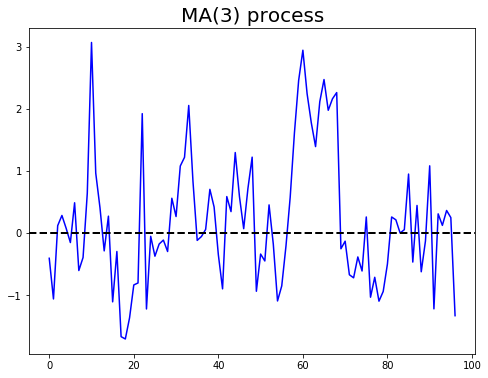

In [55]:
T = 100
p=3
#generating and visualizing MA(3) process
theta=[1, 0.5, 0.3, 0.2]
np.random.seed(2014)
y=np.random.normal(0, 1, T)
x=0
for k in range(0,p+1):
    x=x+theta[k]*y[range(p-k,T-k)]
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
#plt.ylim(-4, 4)
plt.title('MA(3) process', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

### 2. Autoregressive Processes AR(q)
This process would model the rule that "Today is mostly yesterday plus a little noise."
We can write the AR(1) process as follows: 
$$
X_t = \rho X_{t-1} + Y_t
$$ 
In case $\rho=1$ this is a random walk process.  

For $|\rho|<1$ this process is stationary and

$\displaystyle {Cov(X_t, X_{t-1})= E(X_t \cdot X_{t-1}) = \frac{\rho}{1-\rho^2}}$

Indeed, for any $k$,

$\displaystyle {Cov(X_t, X_{t-k})= \frac{\rho^k}{1-\rho^2}}$

More importantly, since correlation is defined as covariance divided by variance, for any AR(1) process, $y_t$, 
the "autocorrelation" function is simply:

$\displaystyle {Corr(X_t, X_{t-k})= \rho^k}$

Here, autocorrelation simply means "correlated with itself through time".

Therefore, in summary, the AR(1) process, $X_t$, has the following characteristics:

1. Zero mean.
2. Finite variance.
3. Autocorrelation function that decays geometrically, $\rho^k$, over $k$ periods.  Note that for $k=0$, correlation is 1 (as it should be).

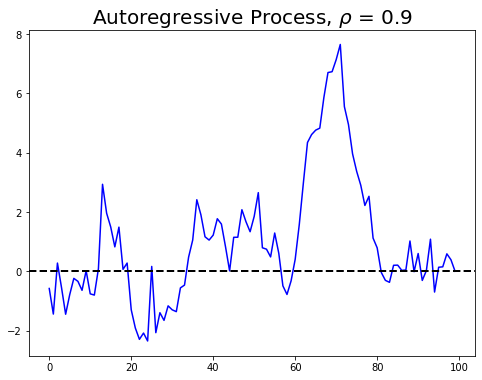

In [56]:
np.random.seed(2014)
#generating and visualizing AR(1) process
T = 99
rho = 0.9
x = np.zeros(T+1)

x[0] = np.random.normal(0, 1)

for t in range(1, T):
    x[t] = rho * x[t-1] + np.random.normal(0, 1)

r = rho
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

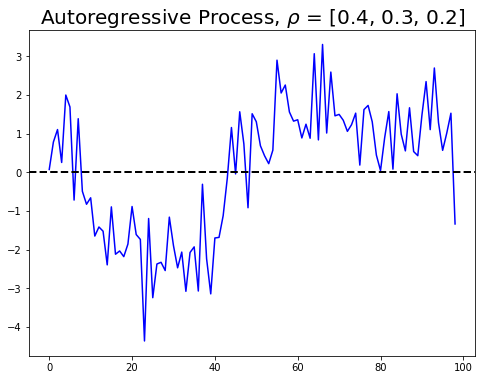

In [57]:
np.random.seed(2011)
#generating and visualizing AR(3) process
T = 99
rho = [0.4, 0.3, 0.2]
x = np.zeros(T+1)

x = np.random.normal(0, 1, 3)

for t in range(3, T):
    x=np.append( x, rho [0] * x[t-1] + rho [1] * x[t-2] + rho [2] * x[t-3] + np.random.normal(0, 1))

r = rho
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

Now further generalizing AR(q):
$$
X_t = \sum_{j=1}^q \rho_j X_{t-j} + Y_t.
$$

### 4.3. ARMA(p,q)
Combining both together
$$
X_t = Y_t+\sum_{j=1}^p \theta_j Y_{t-j}+\sum_{j=1}^q \rho_j X_{t-j}.
$$

In [59]:
"""
Random generation of Gaussian ARMA(p,q) time series from http://stats.stackexchange.com/questions/37437/random-generation-of-arma2-2-gaussian-time-series

INPUTS

phi:      An array of length p with the AR coefficients (the AR part of 
          the ARMA model).

theta:    An array of length q with the MA coefficients (the MA part of 
          the ARMA model).

sigma:    Standard deviaton of the Gaussian noise.

n:        Length of the returned time-series.

burnin:   Number of datapoints that are going to be discarded (the higher 
          the better) to avoid dependence of the ARMA time-series on the 
          initial values.
""" 

from numpy.random import normal
from numpy import *
def ARMAgenerator(phi,theta,sigma,n,burnin=0,verbose=0):
    l=max(len(phi),len(theta))
    if(burnin==0):
        burnin=10*l # Burn-in elements!
    w=normal(0,sigma,n+burnin)
    ARMA=array([])
    s=0.0
    l=max(len(phi),len(theta))
    for i in range(n+burnin):
        if(i<l):
            ARMA=append(ARMA,w[i])
        else:
            s=0.0
            for j in range(len(phi)):
                s=s+phi[j]*ARMA[i-j-1]
            for j in range(len(theta)):
                s=s+theta[j]*w[i-j-1]
            ARMA=append(ARMA,s+w[i])
    if(verbose!=0):
        print ('Measured standard deviation: '+str(sqrt(var(w[burnin:]))))
    return ARMA[burnin:]

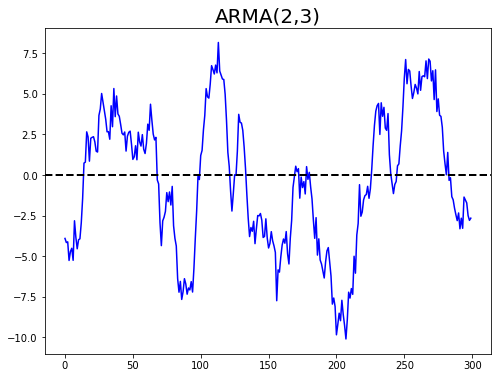

In [60]:
random.seed(2011)
x=ARMAgenerator([0.5, 0.4],[0.4,0.3,0.2],1,300)
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
plt.title(r'ARMA(2,3)', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

### 4.4. ARIMA(p,q,r)
Now ARIMA is a discrete integration of ARMA. If 
$$
\nabla X_t=X_t-X_{t-1}=Y_t \sim ARMA(p,q)
$$
then process $\{X_t\}\sim ARIMA(p,q,1)$. Similarly if 
$$
\nabla X_t\sim ARIMA(p,q,1),
$$
i.e. 
$$
\nabla^2 X_t\sim ARMA(p,q)
$$ 
then $\{X_t\}\sim ARIMA(p,q,2)$. Finally we say $\{X_t\}\sim ARIMA(p,q,r)$ if
$$
\nabla^r X_t\sim ARMA(p,q).
$$ 

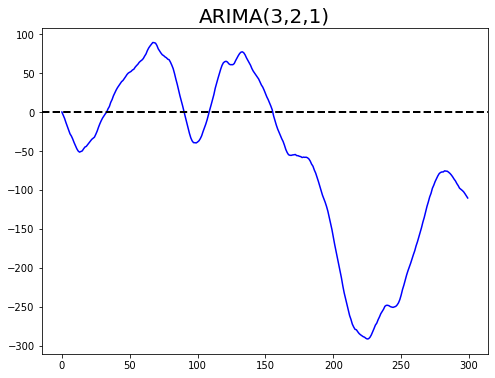

In [61]:
T = 300
x1=[0]
for t in range(1, T):
    x1=np.append( x1, x1[t-1] + x[t])

plt.figure(figsize = (8, 6))
plt.plot(x1, 'b')
plt.title(r'ARIMA(3,2,1)', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

## ARIMA Models for taxi data

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average(ARMA) and adds the notion of integration. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

- **p**: The number of lag observations included in the model, also called the lag order.
- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
- **q**: The size of the moving average window, also called the order of moving average.
A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

Let us see if the time-series is already series and d = 0. We can use ADFuller test to confirm this. 

In [62]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sg

series=hourlyData['fhv']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.521747
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas.
**Autocorrelation** plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. See the Wikipedia entry for more about autocorrelation plots.

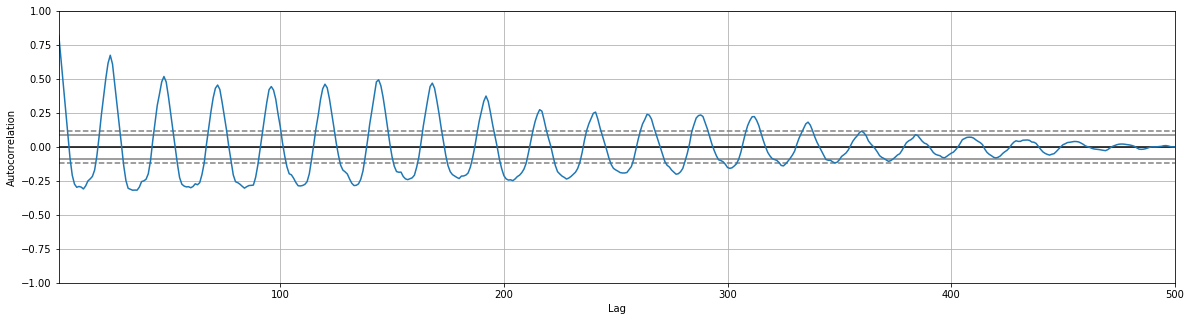

In [63]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize = (20,5))
autocorrelation_plot(series[0:500])
plt.show()

The statsmodels library provides the capability to fit an ARIMA model.

An ARIMA model can be created using the statsmodels library as follows:

Define the model by calling ARIMA() and passing in the p, d, and q parameters.
The model is prepared on the training data by calling the fit() function.
Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.
Let’s start off with something simple. We will fit an ARIMA model to the entire dataset and review the residual errors.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

                              ARMA Model Results                              
Dep. Variable:                    fhv   No. Observations:                 4320
Model:                     ARMA(4, 4)   Log Likelihood              -22264.622
Method:                       css-mle   S.D. of innovations             41.875
Date:                Tue, 19 Nov 2019   AIC                          44549.244
Time:                        12:19:31   BIC                          44612.954
Sample:                             0   HQIC                         44571.739
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        156.7918      1.635     95.885      0.000     153.587     159.997
ar.L1.fhv      2.8159      0.033     84.440      0.000       2.751       2.881
ar.L2.fhv     -3.5187      0.074    -47.730      0.0

<Figure size 1440x720 with 0 Axes>

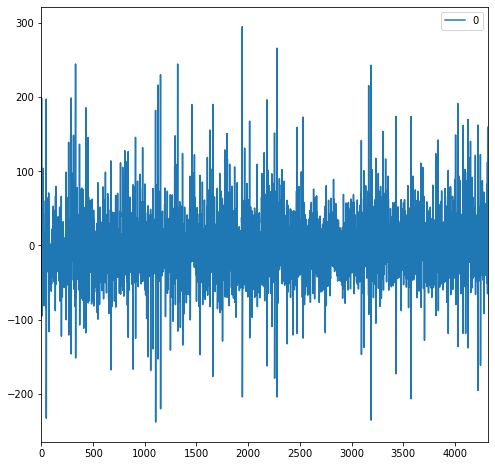

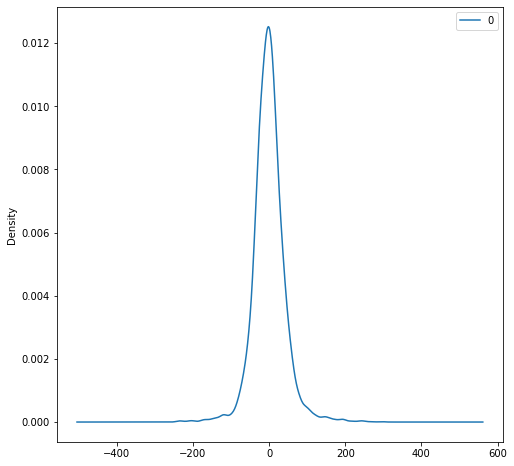

                 0
count  4320.000000
mean      0.032602
std      41.896908
min    -237.871448
25%     -22.627200
50%      -1.363800
75%      19.901100
max     294.810417


In [64]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

P=4
Q=4
R=0
 # fit model
N=180*24    
model = ARIMA(series[:N], order=(P,R,Q))
model_fit = model.fit(disp = 0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize = (20,10))
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

First, we get a line plot of the residual errors, suggesting that the trend is likely already taken care of in the ARIMA model.
Next, we get a density plot of the residual error values.
Finally distribution of the residual errors is displayed.

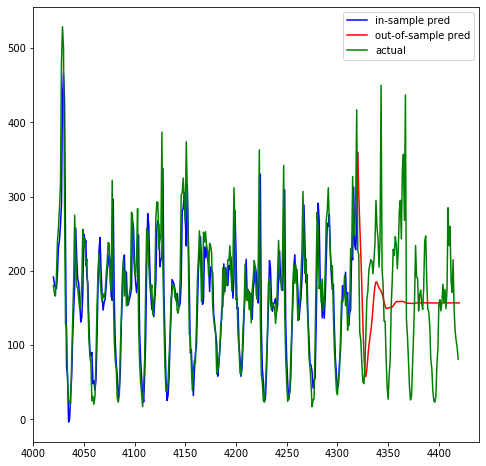

In [65]:
#ARMA prediction
plt.plot((R==1)*series[N-300]+model_fit.predict(start=N-300, end=N),'b')
plt.plot((R==1)*series[N-300]+model_fit.predict(start=N, end=N+100),'r')
plt.plot(series[N-300:N+100],'g')
plt.legend(['in-sample pred','out-of-sample pred','actual'])